In [2]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns 
sns.set()

# Research proposal

This research proposal will investigate causes of death in US inpatient medical facilities and how they have changed from 2008 vs 2018. With major advances in many areas of healthcare over the last decade, the purpose of the study is evaluate whether this data can improve decisions related to future hospital center expansions and research funding. 

Broadly, the proposal will ask whether there are shifts in cause of death percentages over time among different age groups and whether causes have changed between men and women. One hypothesis is that improved cancer intervention over the last decade will have resulted in lower cancer-related deaths in 2018 compared to 2008, such as breast cancer due to early detection. If overall cancer deaths are unchanged, the study will test whether the the age at which people are dying from certain types of cancers to an older age cohort. It will also be interesting to look for unexpected changes in causes of death among certain populations such as in childhood deaths and how they have changed over 10 years. In conclusion, these data will be useful to inform medical research funding agencies and hospitals on how to specifically allocate resources.

Using the data from CDC, I will test cause of death incidence over 10 years in increments of 2 years by a diagnosis code known as the ICD-10 system. This system classifies main categories of causes of death by "chapters". The chapters are broken down by several more specific layers of diagnosis codes. Here I will only focus on chapters (22 in total) and some more specific types of heart disease, infections, and cancer types. The chapter list is provided below.



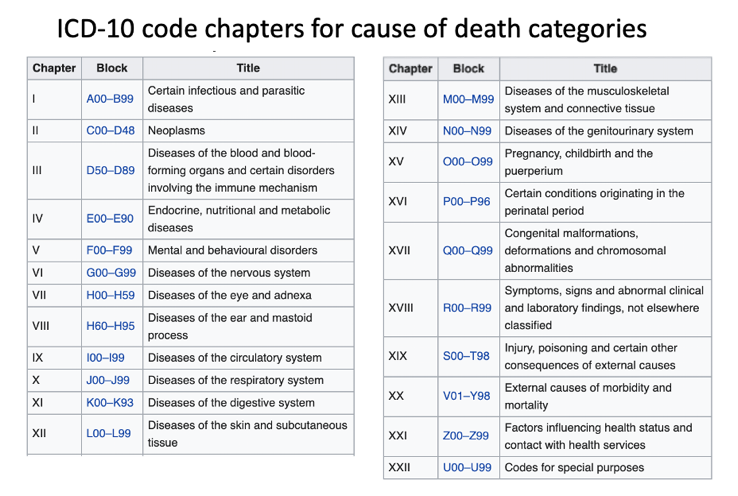

None of the tests will be paired t-test even though time will be a variable, since people only die once. ANOVA will be a good statistical testing tool to measure if there are overall changes in between causes of death, at least at between the 2008 and 2018 years. Depending on the distribution type of the population, the parametric or nonparamentric test will be selected to compare specific causes of death between over time.

Query Criteria:\
Title:	US Cause of death 2008 and 2018 in medical facilities in two year increments

Place of Death: Medical Facility - Inpatient
                
Year/Month:	2008, 2010, 2012, 2014, 2016, and 2018\
Group by: Cause of death; Ten-Year Age Groups; Gender\
Calculate Rates Per:	100,000\
Basic search criteria example:\
https://wonder.cdc.gov/controller/saved/D76/D82F820

Good resource to understand death rate calculations:
https://www.stats.indiana.edu/vitals/CalculatingARate.pdf

Source:\
Centers for Disease Control and Prevention, National Center for Health Statistics. Underlying Cause of Death 1999-2018 on CDC WONDER Online Database, released in 2020. Data are from the Multiple Cause of Death Files, 1999-2018, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/ucd-icd10.html on May 1, 2020 5:00:25 PM


# Data set assembly


The initial table shows more specific causes of death. I will be joining a chapter table to group the more specific codes to the chapter code to simplify the classification of causes of death. However, this is still in progress

In [3]:
# Queried table from CDC

dfcodraw = pd.read_csv('https://raw.githubusercontent.com/robholmstrom/Sams_github/master/Capstone_1/COD_csv_files/US_2008-2018_COD_chapters.csv')
dfcodraw.info()
dfcodraw.head(100)
oldagecode = dfcodraw['Ten-Year Age Groups Code'].values.tolist()
np.unique(oldagecode)

#change age ranges to a numerical integer value
agecodedict = {'1': 0, '14-May': 2, '15-24': 3, '25-34' : 4, '35-44':5, '4-Jan':1, '45-54':6,
       '55-64':7, '65-74':8, '75-84':9, '85+':10}
dfcodraw['Ten-Year Age Groups Code']= dfcodraw['Ten-Year Age Groups Code'].replace(agecodedict)
dfcodraw.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Notes                       80 non-null     object 
 1   ICD-10 113 Cause List       6710 non-null   object 
 2   ICD-10 113 Cause List Code  6710 non-null   object 
 3   Ten-Year Age Groups         6710 non-null   object 
 4   Ten-Year Age Groups Code    6710 non-null   object 
 5   Gender                      6710 non-null   object 
 6   Gender Code                 6710 non-null   object 
 7   Year                        6710 non-null   float64
 8   Year Code                   6710 non-null   float64
 9   Deaths                      6710 non-null   float64
 10  Population                  6710 non-null   object 
 11  Crude Rate                  6710 non-null   object 
dtypes: float64(3), object(9)
memory usage: 636.7+ KB


,Notes,ICD-10 113 Cause List,ICD-10 113 Cause List Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Gender,Gender Code,Year,Year Code,Deaths,Population,Crude Rate
0,NaN,#Salmonella infections (A01-A02),GR113-001,< 1 year,0,Female,F,2010.0,2010.0,1.0,Not Applicable,Not Applicable
1,NaN,#Salmonella infections (A01-A02),GR113-001,< 1 year,0,Female,F,2012.0,2012.0,1.0,Not Applicable,Not Applicable
2,NaN,#Salmonella infections (A01-A02),GR113-001,< 1 year,0,Male,M,2008.0,2008.0,2.0,Not Applicable,Not Applicable


In [4]:

# Get rid of unnecessary columns that were adding null values or just noise

dfcod = dfcodraw.drop(['Gender Code','Notes', 'Population', 'Crude Rate', 'Year Code', 'ICD-10 113 Cause List Code'], axis = 1)

dfcod.dropna(inplace = True)

# Rename some columns for clarity:

dfcod.rename(columns = {'Deaths': 'Deaths per 100,000', 
                        'Ten-Year Age Groups':'Age range', 'Ten-Year Age Groups Code':'Age group code',
                        'ICD-10 113 Cause List': 'Cause of death'}, 
                          inplace = True)

# Drop cummulative malignant neoplasia row in order to not double up with individual neoplasias. All other
# causes of death in the list do not overlap with one another

dfcod = dfcod[dfcod['Cause of death'] != '#Malignant neoplasms (C00-C97)']

dfcod.info() # Ensure that all columns do not contain null values
len(dfcod)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6567 entries, 0 to 6709
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cause of death      6567 non-null   object 
 1   Age range           6567 non-null   object 
 2   Age group code      6567 non-null   object 
 3   Gender              6567 non-null   object 
 4   Year                6567 non-null   float64
 5   Deaths per 100,000  6567 non-null   float64
dtypes: float64(2), object(4)
memory usage: 359.1+ KB


6567

In [5]:
dfcod.head(20) # Example of table with expanded list of 70 causes of death. Will subcategorize these later



,Cause of death,Age range,Age group code,Gender,Year,"Deaths per 100,000"
0,#Salmonella infections (A01-A02),< 1 year,0,Female,2010.0,1.0
1,#Salmonella infections (A01-A02),< 1 year,0,Female,2012.0,1.0
2,#Salmonella infections (A01-A02),< 1 year,0,Male,2008.0,2.0
3,#Salmonella infections (A01-A02),< 1 year,0,Male,2012.0,1.0
4,#Salmonella infections (A01-A02),< 1 year,0,Male,2014.0,2.0
5,#Salmonella infections (A01-A02),< 1 year,0,Male,2018.0,2.0
6,#Salmonella infections (A01-A02),1-4 years,1,Female,2008.0,1.0
7,#Salmonella infections (A01-A02),1-4 years,1,Female,2012.0,1.0
8,#Salmonella infections (A01-A02),1-4 years,1,Female,2014.0,1.0
9,#Salmonella infections (A01-A02),1-4 years,1,Male,2012.0,1.0


In [6]:
# Unique causes of death:
print(np.unique(dfcod['Cause of death']))

['#Accidents (unintentional injuries) (V01-X59,Y85-Y86)'
 '#Alzheimer disease (G30)' '#Anemias (D50-D64)'
 '#Aortic aneurysm and dissection (I71)'
 '#Arthropod-borne viral encephalitis (A83-A84,A85.2)'
 '#Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)' '#Atherosclerosis (I70)'
 '#Cerebrovascular diseases (I60-I69)'
 '#Certain conditions originating in the perinatal period (P00-P96)'
 '#Cholelithiasis and other disorders of gallbladder (K80-K82)'
 '#Chronic liver disease and cirrhosis (K70,K73-K74)'
 '#Chronic lower respiratory diseases (J40-J47)'
 '#Complications of medical and surgical care (Y40-Y84,Y88)'
 '#Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)'
 '#Diabetes mellitus (E10-E14)' '#Diseases of appendix (K35-K38)'
 '#Diseases of heart (I00-I09,I11,I13,I20-I51)'
 '#Enterocolitis due to Clostridium difficile (A04.7)'
 '#Essential hypertension and hypertensive renal disease (I10,I12,I15)'
 '#Hernia (K40-K46)'
 '#Human immunodeficiency virus (HIV) disea

# Preliminary analysis

<BarContainer object of 70 artists>

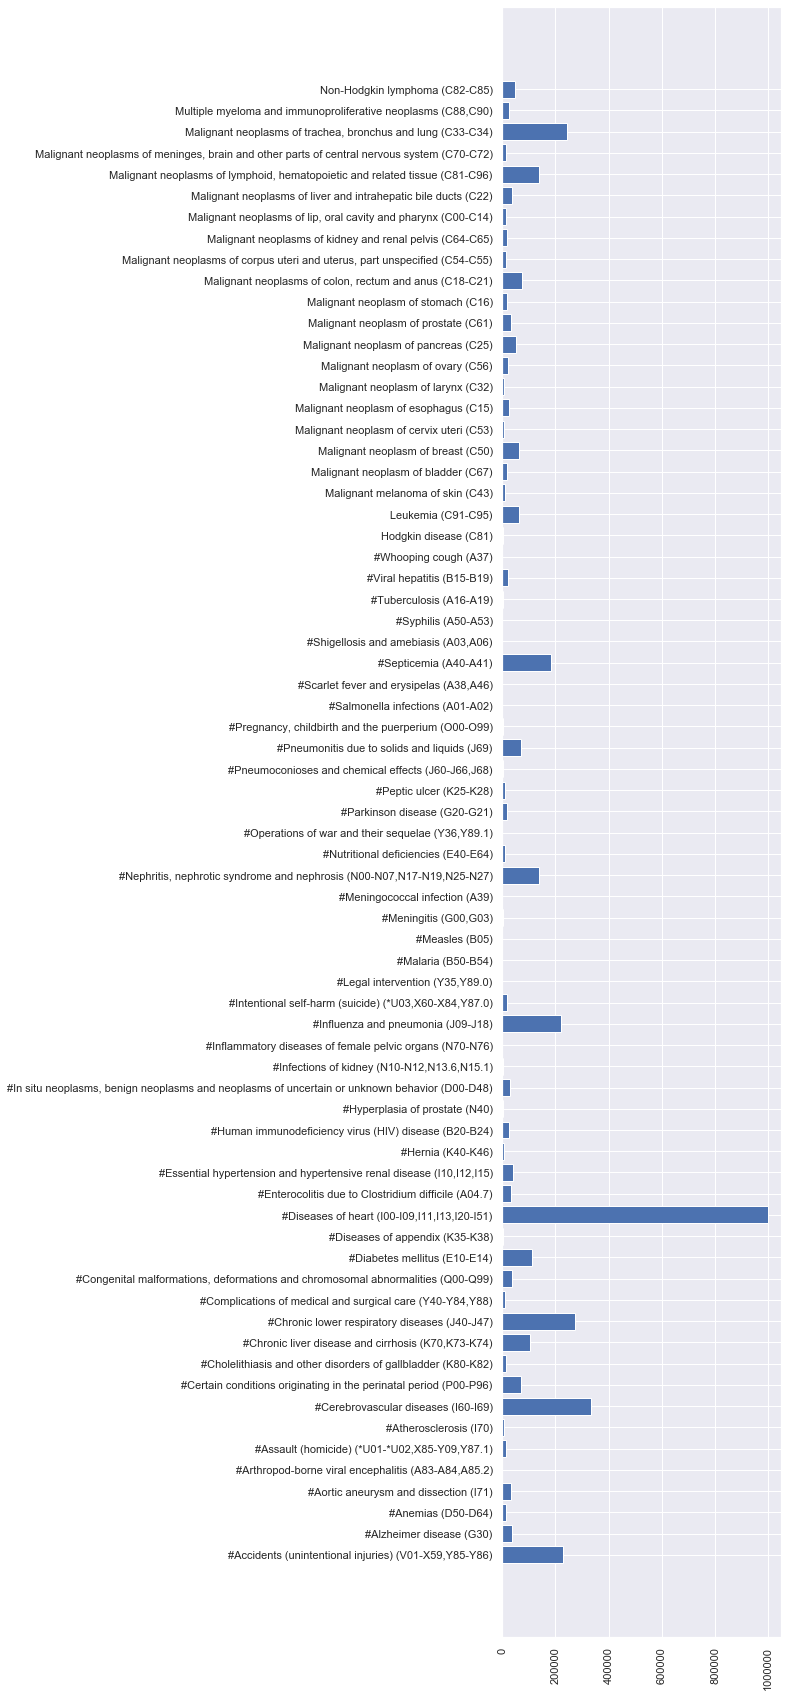

In [7]:
# Initial analysis of average causes of deaths over the 10 years (2008-2018)
groupedcod = dfcod.groupby('Cause of death').sum().reset_index()

plt.figure(figsize=(5,30))
plt.xticks(rotation=90)
plt.barh(groupedcod['Cause of death'], width=groupedcod['Deaths per 100,000'])



Cancer (Malignant neoplasms), when summed (calculated it elsewhere), and heart disease are at the top. Subsequent analysis will look at trends over time, i.e. changes that may have happened over 10 years in regards to incidence of death related to specific cancers and subcategories of heart diseases. A new column that match 70 above causes of death will be broadly binned into one of 22 ICD10 chapter titles. Then it will be easier to look at changes over time and how any changes have occurred for men vs women and whether changes have occurred by age groups.

# Tidy up of data set with simpler categorization

Below, I am creating a new table from which I want to add a broader cause of death categorization using the ICD-10 chapters listed in the earlier part of this notebook.

In [8]:
# Use this to convert cause of death column to a list: list = df['Name'].values.tolist()
cod = dfcod['Cause of death'].values.tolist()

# Get cause of death list to create a code letter column that will match with a chapter letter. 
# Will eventually populate adjacent column with broader chapter category based on letter


icd10 = []
for x in cod: # Generate list first letter of ICD codes to associate with cause of death
    codepos = len(x.split(' '))-1 # position of icd code in each cause of death string in the list
    rawcode = x.split(' ')[codepos] # defines the icd code from cod string with paretheses
 
    if rawcode[1:len(rawcode)-1][0] == '*': # removes paretheses and returns letter of chapter
        codeletter ='U'
    elif rawcode[1:len(rawcode)-1][0] == 'B': # combines A and B codes within the same chapter letter (as A)
        codeletter = 'A'
    elif rawcode[1:len(rawcode)-1][0] == 'T': # similar logic as above for ones below
        codeletter = 'S'
    elif rawcode[1:len(rawcode)-1][0] == 'W':
        codeletter = 'V'
    elif rawcode[1:len(rawcode)-1][0] == 'X':
        codeletter = 'V'
    elif rawcode[1:len(rawcode)-1][0] == 'Y':
        codeletter = 'V'
    # Neoplasias are split between all of C and half of D. Therefore had to extend the definition criteria in
    # the code range string to designate first half of D to C, which I am using as the neoplasm letter code
    elif rawcode[1:len(rawcode)-1][0:7] == 'D00-D48': 
        codeletter = 'C'
    else:
        codeletter = rawcode[1:len(rawcode)-1][0]
   
    icd10.append(codeletter)


# dfcod = pd.DataFrame({'Cause of death': codunique, 'Code letter': icd10})
dfcod['Code letter'] = icd10
dfcod




,Cause of death,Age range,Age group code,Gender,Year,"Deaths per 100,000",Code letter
0,#Salmonella infections (A01-A02),< 1 year,0,Female,2010.0,1.0,A
1,#Salmonella infections (A01-A02),< 1 year,0,Female,2012.0,1.0,A
2,#Salmonella infections (A01-A02),< 1 year,0,Male,2008.0,2.0,A
3,#Salmonella infections (A01-A02),< 1 year,0,Male,2012.0,1.0,A
4,#Salmonella infections (A01-A02),< 1 year,0,Male,2014.0,2.0,A
...,...,...,...,...,...,...,...
6705,#Enterocolitis due to Clostridium difficile (A...,85+ years,10,Male,2012.0,736.0,A
6706,#Enterocolitis due to Clostridium difficile (A...,85+ years,10,Male,2014.0,652.0,A
6707,#Enterocolitis due to Clostridium difficile (A...,85+ years,10,Male,2016.0,603.0,A
6708,#Enterocolitis due to Clostridium difficile (A...,85+ years,10,Male,2018.0,408.0,A


In [9]:
# import a list of ICD chapters to match with dfcod causes of death:    
icdchapters = pd.read_csv('https://raw.githubusercontent.com/robholmstrom/Sams_github/master/Capstone_1/COD_csv_files/ICD10chaptersnew.csv', header=None)
icdchapters.rename(columns={0:"ICD10 code range", 1:"Cause of death chapter"}, inplace=True)

# Make a code letter list that will be added as a column in the icd chapter table--will act as primary key in table merge with dfcod
chapletter = []
for x in icdchapters['ICD10 code range']:

    if x[0] == '*': # returns letter of chapter for each code range
        letter ='U'# This one is special since U letters start with an asterix for some reason

    else:
        letter = x[0]
  
    chapletter.append(letter) # makes  the chapter letter list
icdchapters['Code letter'] = chapletter # reinsert into the dataframe to associate with respective chapter name

icdchapters


,ICD10 code range,Cause of death chapter,Code letter
0,A00 B99,Certain infectious and parasitic diseases,A
1,C00 D48,Neoplasms,C
2,D50 D89,Diseases of the blood and blood-forming organs...,D
3,E00 E90,"Endocrine, nutritional and metabolic diseases",E
4,F00 F99,Mental and behavioural disorders,F
5,G00 G99,Diseases of the nervous system,G
6,H00 H59,Diseases of the eye and adnexa,H
7,H60 H95,Diseases of the ear and mastoid process,H
8,I00 I99,Diseases of the circulatory system,I
9,J00 J99,Diseases of the respiratory system,J


In [10]:
#Merge tables to have chapter associated with specific cause of death in the dfcod table
dfcodchap = pd.merge(dfcod, icdchapters, on ='Code letter', how = 'left') 
dfcodchap.head(200)


,Cause of death,Age range,Age group code,Gender,Year,"Deaths per 100,000",Code letter,ICD10 code range,Cause of death chapter
0,#Salmonella infections (A01-A02),< 1 year,0,Female,2010.0,1.0,A,A00 B99,Certain infectious and parasitic diseases
1,#Salmonella infections (A01-A02),< 1 year,0,Female,2012.0,1.0,A,A00 B99,Certain infectious and parasitic diseases
2,#Salmonella infections (A01-A02),< 1 year,0,Male,2008.0,2.0,A,A00 B99,Certain infectious and parasitic diseases
3,#Salmonella infections (A01-A02),< 1 year,0,Male,2012.0,1.0,A,A00 B99,Certain infectious and parasitic diseases
4,#Salmonella infections (A01-A02),< 1 year,0,Male,2014.0,2.0,A,A00 B99,Certain infectious and parasitic diseases
...,...,...,...,...,...,...,...,...,...
195,#Tuberculosis (A16-A19),75-84 years,9,Male,2014.0,55.0,A,A00 B99,Certain infectious and parasitic diseases
196,#Tuberculosis (A16-A19),75-84 years,9,Male,2016.0,47.0,A,A00 B99,Certain infectious and parasitic diseases
197,#Tuberculosis (A16-A19),75-84 years,9,Male,2018.0,53.0,A,A00 B99,Certain infectious and parasitic diseases
198,#Tuberculosis (A16-A19),85+ years,10,Female,2008.0,34.0,A,A00 B99,Certain infectious and parasitic diseases


# Analysis

<BarContainer object of 14 artists>

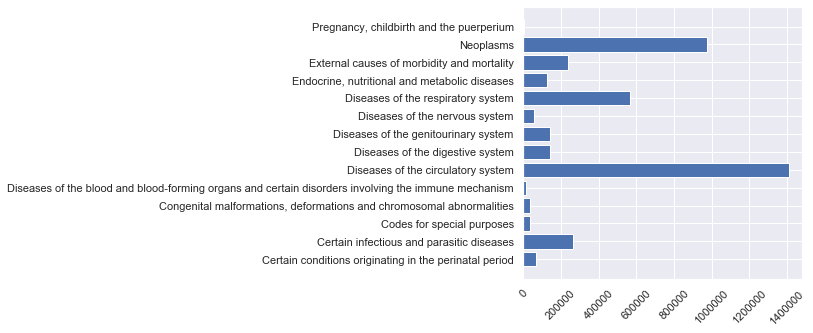

In [11]:
# Re analysis of summed causes of deaths over the 10 years (2008-2018) by condensed ICD chapter list

groupedcodchap = dfcodchap.groupby(['Cause of death chapter']).sum().reset_index()

plt.figure(figsize=(5,5))
plt.xticks(rotation=45)
plt.barh(groupedcodchap['Cause of death chapter'], width=groupedcodchap['Deaths per 100,000'])

# I would like to graph these so that they are subgrouped by gender and year. Still trying to remember how to 
# select colums and row criteria to plot, say for only neoplasms and for years 2008 and 2018. Also how to plot 
# histograms from select data from this dataframe.

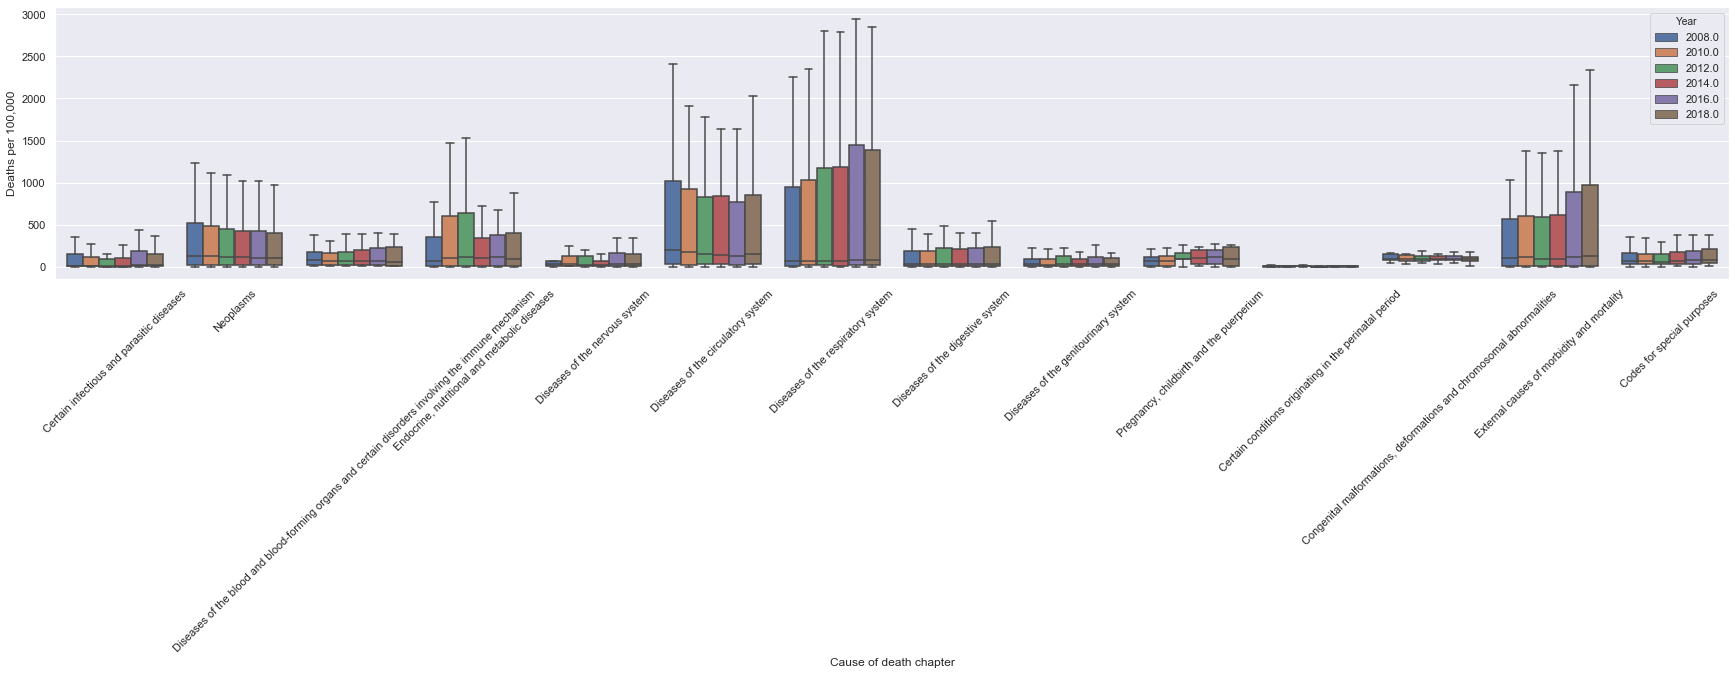

In [12]:
# Trend of death rates for ICD10 chapter categories over 10 years in increments of two years

pd.set_option('display.max_rows', 900)
groupedcodchap = dfcodchap.groupby(['Cause of death chapter', 'Gender'])
groupedcodchap.sum()

dfcodchap.sum()
plt.figure(figsize=(30,5))
plt.xticks(rotation=45)
sns.boxplot('Cause of death chapter', 'Deaths per 100,000', hue = 'Year', showfliers= False, data = dfcodchap)


The time to get the dataframes in shape to analyze relationships has taken longer than expected. I probably should have chosen a data set with less fixed variables and more continuous variables.

In regard to the initial questions:

1. Is there a difference in death rates overall in the population over the decade and is there a difference between death rates occurring in men vs women.

The question I am having difficulty with is that since the death rates are from the population, there isn't really a mean. It is a sum for each year. The mean, even for each year, is generated from the subcategories of death and the age ranges. This produces an enormous variance, since there are huge differences in death rates within the subcategories (rare cancer vs common) and skewed distribution in age groups. Therefore the mean is not appropriately weighted for age groups and brings down the percieved death rate. E.g. boxplot of neoplasms rates appears less blood disease and immune mechanisms, but cancer is acutally the second highest cause of death in inpatient settings each year. 

It will be useful to plot cause of death by age and see whether the distributions are different from 2008 and 2018. More simply, one could use a linear regression to test whether there is correlation in time (five timepoints over 10 years) vs death rates for the different causes of death and then hue that by gender. 

2. Is there a difference in deaths from cancer from year 2008 and 2018?

One could calculate the Baysean probability of dying from cancer in the year 2008 vs year 2018 and stratify that by age group. However, I am still trying to figure out how to do that.



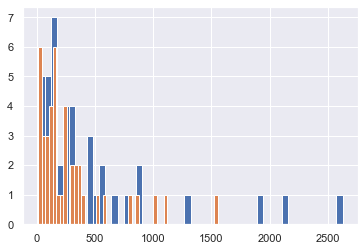

In [39]:
dfdecF = dfcodchap.loc[(dfcodchap['Code letter']=='C') & dfcodchap['Year'].isin([2008.0,2018.0]) & dfcodchap['Age group code'].isin([2,3,4,5,6,7,8,9,10])]

dfdecF608 = dfdecF.loc[(dfdecF['Age group code'] == 6) & (dfdecF['Year'] == 2008)]
dfdecF618 = dfdecF.loc[(dfdecF['Age group code'] == 6) & (dfdecF['Year'] == 2018)]
# plt.figure(figsize=(20,5))
# sns.barplot('Age group code','Deaths per 100,000', data=dfdecF)

dfdecF608['Deaths per 100,000'].hist(bins=50)
dfdecF618['Deaths per 100,000'].hist(bins=50)


In [38]:
stats.kruskal(dfdecF608['Deaths per 100,000'],dfdecF618['Deaths per 100,000'])

KruskalResult(statistic=0.9721748715122384, pvalue=0.32413837056681816)

In [44]:
df1 = pd.DataFrame({'x':[2,3,3,3,4,4,4,4,4,5,5,5,5,6],'y':[2,2,3,3,3,4,4,4,4,4,4,5,5,5]})
df1


,x,y
0,2,2
1,3,2
2,3,3
3,3,3
4,4,3
5,4,4
6,4,4
7,4,4
8,4,4
9,5,4


In [ ]:
stats.ttest_ind()